## Import Dataset

In [1]:
import os

import numpy
from torchvision import transforms
from torch.utils.data import DataLoader
from oracle import MNIST, OracleMNIST

# 改进自ResNet-9
# 原始代码和模型参考自 https://github.com/Tanuj-tj/Flowers_Recognition_Project/blob/main/FlowerReco_ResNet9.ipynb
# 原始模型直接测试 MNIST 99.5% Oracle 88%
# 改进后模型 Oracle 95.83%±0.29%(最高96.37%) MNIST 99.5%±0.03%


#变种研究4 改变batch
# 256 -> 0.944±0.0050 训练速度 23it/s 5888samp/s
# 64 -> 0.956±0.0007 训练速度 85it/s 5440samp/s
# 32 -> 0.957±0.0020 训练速度 105it/s 3360samp/s
# 16 -> 0.958±0.0030 训练速度 125it/s 2000samp/s
# 最终选取64
batch_size = 64
# dataSource = lambda train: MNIST(root="datasets", train=train, download=True, transform=transforms.ToTensor())
dataSource = lambda train: OracleMNIST(root="datasets", train=train, download=True, transform=transforms.ToTensor())

trainData = dataSource(True)
testData = dataSource(False)
trainDL = DataLoader(trainData, batch_size, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
testDL = DataLoader(testData, batch_size, num_workers=os.cpu_count(), pin_memory=True)

## Dataset preview

TrainData Length:  27222
TestData Length:  3000
Classes:  ['0 - big - 大', '1 - sun - 日', '2 - moon - 月', '3 - cattle - 牛', '4 - next - 翌', '5 - field - 田', '6 - not - 勿', '7 - arrow - 矢', '8 - time 9-11 am - 巳', '9 - wood - 木']
A Perticular Element:  torch.Size([1, 28, 28]) Label:  4 - next - 翌


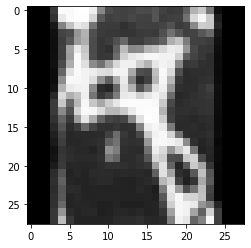

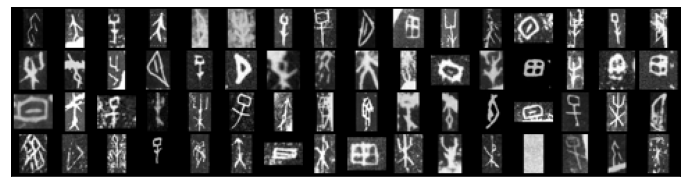

In [2]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

print("TrainData Length: ", len(trainData))
print("TestData Length: ", len(testData))
print("Classes: ", trainData.classes)

img, label = trainData[0]
print("A Perticular Element: ", img.shape, "Label: ", trainData.classes[label])
plt.imshow(img[0], cmap="gray")  # Looking at the first image
del img, label


def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=16).permute(1, 2, 0))
        break


show_batch(trainDL)

## Model Utilities

In [3]:
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm, trange


def mergeResult(mode, outputs):
    loss = torch.stack([x[0] for x in outputs]).mean().item()
    acc = numpy.average([x[1] for x in outputs])
    return {mode + '_loss': loss, mode + '_acc': acc}


@torch.no_grad()
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


def step(model, batch):
    images, labels = batch
    out = model(images)  # Generate predictions
    loss = F.cross_entropy(out, labels)  # Calculate loss
    acc = accuracy(out, labels)  # Calculate accuracy
    return loss, acc


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    val_loader = tqdm(val_loader, "evaluate", leave=False)
    outputs = [step(model, batch) for batch in val_loader]
    return mergeResult('val', outputs)


def fit(model, optimizer, epoch, train_loader, val_loader):
    # Training Phase
    model.train()
    outputs = []
    for batch in tqdm(train_loader, "train", leave=False):
        (loss, acc) = step(model, batch)
        outputs.append((loss, acc))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    result = mergeResult('train', outputs)
    # Validation phase
    result.update(evaluate(model, val_loader))
    return result


def plot_accuracies(history):
    accuraciesT = [x.get('train_acc') for x in history]
    accuraciesV = [x.get('val_acc') for x in history]
    plt.plot(accuraciesT, '-bx')
    plt.plot(accuraciesV, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')


def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x.get('val_loss') for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

### Device Util

In [4]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader:
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


if os.getenv('COLAB_TPU_ADDR'):
    get_ipython().system(
        "pip install cloud-tpu-client==0.10 torch==1.11.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.11-cp37-cp37m-linux_x86_64.whl")
    import torch_xla.core.xla_model as xm

    device = xm.xla_device()
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", device)

if not isinstance(trainDL, DeviceDataLoader):
    trainDL = DeviceDataLoader(trainDL, device)
    testDL = DeviceDataLoader(testDL, device)

device cuda


## Model

In [5]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


def linear_ReLU(in_channels, out_channels):
    return nn.Sequential(
        nn.Linear(in_channels, out_channels),
        nn.ReLU(),
    )


# 变种研究5 改进DropConnect
# 增加选择权值w 训练精确度达到0.994 测试精确度0.957±0.0021
# 原始forward代码：self.f(x) + x
class DropConnect(nn.Module):
    def __init__(self, f: nn.Module):
        super().__init__()
        self.w = nn.Parameter(Tensor([0.5]))
        self.f = f

    def forward(self, x: Tensor):
        return (1 - self.w) * self.f(x) + self.w * x


class DropConnectWithPool(DropConnect):
    def forward(self, x: Tensor):
        return (1 - self.w) * F.max_pool2d(self.f(x), 2) + self.w * F.max_pool2d(x, 2)


class ResNet9(nn.Sequential):
    def __init__(self, in_channels, num_classes):
        super().__init__(
            conv_block(in_channels, 64, ),
            # 变种研究2(变种1选择4层)：使用单个64->64卷积块 91.7%
            # 变种代码
            # conv_block(64, 64, pool=True),

            # 变种研究7: DropConnectWithPool代替普通池化卷积
            # 实验结果 0.9606±0.00146
            # 有比较明显提升，故保留变种。原始代码：
            # conv_block(64, 128, pool=True),
            # conv_block(128, 64, pool=True),
            DropConnectWithPool(conv_block(64, 64)),
            DropConnectWithPool(conv_block(64, 64)),

            # DropConnect 卷积层
            # 变种研究1: 0层 88% 1层 92.4% 2层 93.6% 3层 0.937±0.01 4层0.944±0.0050 5层 0.944±0.0076(best 0.95444)
            # 最终选择4层
            DropConnect(conv_block(64, 64)),
            DropConnect(conv_block(64, 64)),
            DropConnect(conv_block(64, 64)),
            DropConnect(conv_block(64, 64)),

            # 变种研究7 使用全连接代替AdaptiveAvgPool2d
            # 实验结果: 0.9549±0.00343 (出现过拟合 训练精确度0.9992±0.00064)
            # 不过该变种有后续研究加载，具有极高的训练精确度(最高能达到99.99%)
            # 变种代码：
            # nn.Flatten(),
            # linear_ReLU(64 * 7 * 7, 32),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),

            # DropConnect 全连接层
            # 变种研究3(变种1选择4层): 0层 88% 1层 94.8% 2层 94.7% 3层93%
            # 故选用1层
            # 变种研究6 改进DropConnect后再次尝试
            # 3层 训练精确度 0.995±0.0015 测试精确度 0.958±0.0026
            DropConnect(linear_ReLU(64, 64)),
            DropConnect(linear_ReLU(64, 64)),
            DropConnect(linear_ReLU(64, 64)),
            nn.Linear(64, num_classes)
        )


ResNet9(1, len(trainData.classes))

ResNet9(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (1): DropConnectWithPool(
    (f): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (2): DropConnectWithPool(
    (f): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (3): DropConnect(
    (f): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (4): DropCon

## Training

In [6]:
def doEpoch(epoch):
    result = fit(model, optimizer, epoch, trainDL, testDL)
    result["epoch"] = epoch + 1
    result["lr"] = optimizer.state_dict()['param_groups'][0]['lr']
    scheduler.step(result['train_acc'])
    tqdm.write("Epoch [%d] %s" % (epoch, result))
    history.append(result)


def doRound(round):
    global model, optimizer, scheduler, history
    model = ResNet9(1, len(trainData.classes)).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, threshold_mode='rel', mode='max', patience=1, verbose=False,
        threshold=0.1, factor=0.3, min_lr=0.001)
    history = [evaluate(model, testDL)]

    for epoch in trange(12, desc="EPOCH", leave=False):
        doEpoch(epoch)

    plt.subplot(1, 2, 1)
    plot_accuracies(history)
    plt.subplot(1, 2, 2)
    plot_losses(history)
    plt.show()
    #取最佳结果
    result = history[numpy.argmax([x['val_acc'] for x in history])]
    tqdm.write("Round [%d], train_loss: %.4f, train_acc: %.4f, val_loss: %.4f, val_acc: %.4f, lr: %f" %
               (round, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc'], result["lr"]))
    train_acc.append(result["train_acc"])
    val_acc.append(result["val_acc"])

ROUND:   0%|          | 0/5 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

EPOCH:   0%|          | 0/12 [00:00<?, ?it/s]

train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [0] {'train_loss': 1.1023147106170654, 'train_acc': 0.6015658, 'val_loss': 0.8047641515731812, 'val_acc': 0.7546542, 'epoch': 1, 'lr': 0.1}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [1] {'train_loss': 0.286643385887146, 'train_acc': 0.90544635, 'val_loss': 0.3260667622089386, 'val_acc': 0.8870156, 'epoch': 2, 'lr': 0.1}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [2] {'train_loss': 0.20701536536216736, 'train_acc': 0.92863387, 'val_loss': 0.7640224099159241, 'val_acc': 0.7947379, 'epoch': 3, 'lr': 0.1}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [3] {'train_loss': 0.16142801940441132, 'train_acc': 0.9452791, 'val_loss': 0.21548980474472046, 'val_acc': 0.93108857, 'epoch': 4, 'lr': 0.1}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [4] {'train_loss': 0.08661043643951416, 'train_acc': 0.9712108, 'val_loss': 0.1967545449733734, 'val_acc': 0.93830734, 'epoch': 5, 'lr': 0.03}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [5] {'train_loss': 0.0669286772608757, 'train_acc': 0.9772627, 'val_loss': 0.1752253919839859, 'val_acc': 0.9424392, 'epoch': 6, 'lr': 0.03}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [6] {'train_loss': 0.039761126041412354, 'train_acc': 0.9867257, 'val_loss': 0.15270638465881348, 'val_acc': 0.95260257, 'epoch': 7, 'lr': 0.009}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [7] {'train_loss': 0.03146791830658913, 'train_acc': 0.99057364, 'val_loss': 0.15517030656337738, 'val_acc': 0.9543598, 'epoch': 8, 'lr': 0.009}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [8] {'train_loss': 0.02488383837044239, 'train_acc': 0.99241084, 'val_loss': 0.15961910784244537, 'val_acc': 0.9553097, 'epoch': 9, 'lr': 0.0026999999999999997}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [9] {'train_loss': 0.02279975265264511, 'train_acc': 0.9933979, 'val_loss': 0.1620580404996872, 'val_acc': 0.9549772, 'epoch': 10, 'lr': 0.0026999999999999997}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [10] {'train_loss': 0.020325083285570145, 'train_acc': 0.99398476, 'val_loss': 0.16350726783275604, 'val_acc': 0.9546448, 'epoch': 11, 'lr': 0.001}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [11] {'train_loss': 0.019791102036833763, 'train_acc': 0.99398476, 'val_loss': 0.1636868119239807, 'val_acc': 0.9553097, 'epoch': 12, 'lr': 0.001}


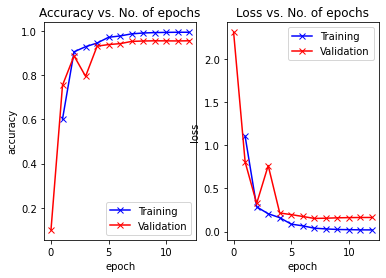

Round [0], train_loss: 0.0249, train_acc: 0.9924, val_loss: 0.1596, val_acc: 0.9553, lr: 0.002700


evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

EPOCH:   0%|          | 0/12 [00:00<?, ?it/s]

train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [0] {'train_loss': 1.0448493957519531, 'train_acc': 0.6255535, 'val_loss': 0.8412083983421326, 'val_acc': 0.7441584, 'epoch': 1, 'lr': 0.1}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [1] {'train_loss': 0.27293911576271057, 'train_acc': 0.9068768, 'val_loss': 1.8181051015853882, 'val_acc': 0.6016337, 'epoch': 2, 'lr': 0.1}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [2] {'train_loss': 0.20026379823684692, 'train_acc': 0.93146473, 'val_loss': 0.7315670251846313, 'val_acc': 0.8178192, 'epoch': 3, 'lr': 0.1}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [3] {'train_loss': 0.16139626502990723, 'train_acc': 0.94494903, 'val_loss': 1.0323944091796875, 'val_acc': 0.7618256, 'epoch': 4, 'lr': 0.1}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [4] {'train_loss': 0.08376489579677582, 'train_acc': 0.9724578, 'val_loss': 0.1557157337665558, 'val_acc': 0.950323, 'epoch': 5, 'lr': 0.03}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [5] {'train_loss': 0.06304796785116196, 'train_acc': 0.97938675, 'val_loss': 0.17151260375976562, 'val_acc': 0.94666606, 'epoch': 6, 'lr': 0.03}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [6] {'train_loss': 0.03765339031815529, 'train_acc': 0.9881195, 'val_loss': 0.14745624363422394, 'val_acc': 0.95868164, 'epoch': 7, 'lr': 0.009}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [7] {'train_loss': 0.028200402855873108, 'train_acc': 0.9910171, 'val_loss': 0.15242229402065277, 'val_acc': 0.9579217, 'epoch': 8, 'lr': 0.009}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [8] {'train_loss': 0.0224742628633976, 'train_acc': 0.9931811, 'val_loss': 0.14542435109615326, 'val_acc': 0.96233857, 'epoch': 9, 'lr': 0.0026999999999999997}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [9] {'train_loss': 0.019031699746847153, 'train_acc': 0.9947216, 'val_loss': 0.15827302634716034, 'val_acc': 0.9600114, 'epoch': 10, 'lr': 0.0026999999999999997}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [10] {'train_loss': 0.019092626869678497, 'train_acc': 0.99482834, 'val_loss': 0.14822782576084137, 'val_acc': 0.9633834, 'epoch': 11, 'lr': 0.001}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [11] {'train_loss': 0.0168849378824234, 'train_acc': 0.9953785, 'val_loss': 0.14713074266910553, 'val_acc': 0.9637158, 'epoch': 12, 'lr': 0.001}


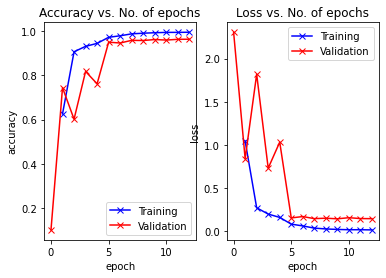

Round [1], train_loss: 0.0169, train_acc: 0.9954, val_loss: 0.1471, val_acc: 0.9637, lr: 0.001000


evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

EPOCH:   0%|          | 0/12 [00:00<?, ?it/s]

train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [0] {'train_loss': 1.02498459815979, 'train_acc': 0.6276876, 'val_loss': 2.268735885620117, 'val_acc': 0.5044168, 'epoch': 1, 'lr': 0.1}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [1] {'train_loss': 0.2758854627609253, 'train_acc': 0.9059932, 'val_loss': 0.40915268659591675, 'val_acc': 0.8663089, 'epoch': 2, 'lr': 0.1}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [2] {'train_loss': 0.1951112002134323, 'train_acc': 0.93471575, 'val_loss': 0.2789132297039032, 'val_acc': 0.9069624, 'epoch': 3, 'lr': 0.1}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [3] {'train_loss': 0.15885870158672333, 'train_acc': 0.9443255, 'val_loss': 0.2708885669708252, 'val_acc': 0.9076273, 'epoch': 4, 'lr': 0.1}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [4] {'train_loss': 0.083462655544281, 'train_acc': 0.97216773, 'val_loss': 0.26357272267341614, 'val_acc': 0.91612846, 'epoch': 5, 'lr': 0.03}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [5] {'train_loss': 0.06447957456111908, 'train_acc': 0.97817636, 'val_loss': 0.16027803719043732, 'val_acc': 0.9492306, 'epoch': 6, 'lr': 0.03}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [6] {'train_loss': 0.03863931819796562, 'train_acc': 0.9876761, 'val_loss': 0.15273050963878632, 'val_acc': 0.955927, 'epoch': 7, 'lr': 0.009}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [7] {'train_loss': 0.029428809881210327, 'train_acc': 0.99108714, 'val_loss': 0.16045799851417542, 'val_acc': 0.9543123, 'epoch': 8, 'lr': 0.009}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [8] {'train_loss': 0.02313425950706005, 'train_acc': 0.9924842, 'val_loss': 0.15510156750679016, 'val_acc': 0.95730436, 'epoch': 9, 'lr': 0.0026999999999999997}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [9] {'train_loss': 0.019960250705480576, 'train_acc': 0.9942048, 'val_loss': 0.16194786131381989, 'val_acc': 0.95393234, 'epoch': 10, 'lr': 0.0026999999999999997}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [10] {'train_loss': 0.018473360687494278, 'train_acc': 0.99464494, 'val_loss': 0.16305455565452576, 'val_acc': 0.9549772, 'epoch': 11, 'lr': 0.001}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [11] {'train_loss': 0.017440879717469215, 'train_acc': 0.99519515, 'val_loss': 0.1661510020494461, 'val_acc': 0.9543123, 'epoch': 12, 'lr': 0.001}


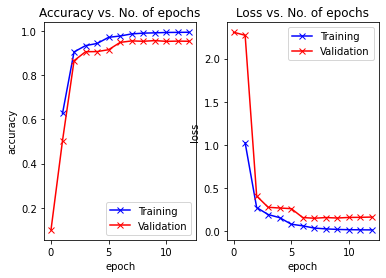

Round [2], train_loss: 0.0231, train_acc: 0.9925, val_loss: 0.1551, val_acc: 0.9573, lr: 0.002700


evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

EPOCH:   0%|          | 0/12 [00:00<?, ?it/s]

train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [0] {'train_loss': 1.0221409797668457, 'train_acc': 0.6346964, 'val_loss': 1.364238977432251, 'val_acc': 0.6451368, 'epoch': 1, 'lr': 0.1}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [1] {'train_loss': 0.27298039197921753, 'train_acc': 0.90864414, 'val_loss': 0.4482194483280182, 'val_acc': 0.84346503, 'epoch': 2, 'lr': 0.1}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [2] {'train_loss': 0.20092299580574036, 'train_acc': 0.932515, 'val_loss': 0.46296367049217224, 'val_acc': 0.8495916, 'epoch': 3, 'lr': 0.1}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [3] {'train_loss': 0.16006900370121002, 'train_acc': 0.94528246, 'val_loss': 0.4292784631252289, 'val_acc': 0.86426675, 'epoch': 4, 'lr': 0.1}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [4] {'train_loss': 0.08661515265703201, 'train_acc': 0.97037053, 'val_loss': 0.2312059998512268, 'val_acc': 0.9201653, 'epoch': 5, 'lr': 0.03}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [5] {'train_loss': 0.0640081837773323, 'train_acc': 0.9780663, 'val_loss': 0.15958186984062195, 'val_acc': 0.953315, 'epoch': 6, 'lr': 0.03}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [6] {'train_loss': 0.03761427104473114, 'train_acc': 0.9881162, 'val_loss': 0.15077747404575348, 'val_acc': 0.95863414, 'epoch': 7, 'lr': 0.009}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [7] {'train_loss': 0.029205022379755974, 'train_acc': 0.99075705, 'val_loss': 0.16426891088485718, 'val_acc': 0.9553572, 'epoch': 8, 'lr': 0.009}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [8] {'train_loss': 0.024046894162893295, 'train_acc': 0.9923342, 'val_loss': 0.16416937112808228, 'val_acc': 0.9563545, 'epoch': 9, 'lr': 0.0026999999999999997}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [9] {'train_loss': 0.021928725764155388, 'train_acc': 0.9936546, 'val_loss': 0.1631980538368225, 'val_acc': 0.956687, 'epoch': 10, 'lr': 0.0026999999999999997}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [10] {'train_loss': 0.019664470106363297, 'train_acc': 0.99413145, 'val_loss': 0.1638474017381668, 'val_acc': 0.9550722, 'epoch': 11, 'lr': 0.001}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [11] {'train_loss': 0.019892482087016106, 'train_acc': 0.9945749, 'val_loss': 0.16672325134277344, 'val_acc': 0.9563545, 'epoch': 12, 'lr': 0.001}


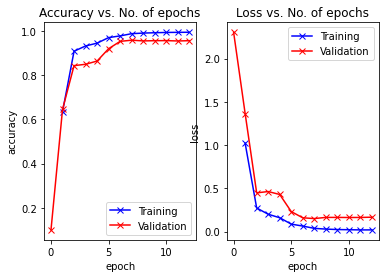

Round [3], train_loss: 0.0376, train_acc: 0.9881, val_loss: 0.1508, val_acc: 0.9586, lr: 0.009000


evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

EPOCH:   0%|          | 0/12 [00:00<?, ?it/s]

train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [0] {'train_loss': 0.9900177717208862, 'train_acc': 0.6434192, 'val_loss': 0.7062419652938843, 'val_acc': 0.7734613, 'epoch': 1, 'lr': 0.1}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [1] {'train_loss': 0.2779718041419983, 'train_acc': 0.9064434, 'val_loss': 5.871731758117676, 'val_acc': 0.26571998, 'epoch': 2, 'lr': 0.1}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [2] {'train_loss': 0.20256957411766052, 'train_acc': 0.9318616, 'val_loss': 1.3701775074005127, 'val_acc': 0.68018615, 'epoch': 3, 'lr': 0.1}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [3] {'train_loss': 0.16158507764339447, 'train_acc': 0.9456859, 'val_loss': 0.35811808705329895, 'val_acc': 0.88934267, 'epoch': 4, 'lr': 0.1}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [4] {'train_loss': 0.08916183561086655, 'train_acc': 0.9695303, 'val_loss': 0.19003769755363464, 'val_acc': 0.93830734, 'epoch': 5, 'lr': 0.03}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [5] {'train_loss': 0.06615691632032394, 'train_acc': 0.97722274, 'val_loss': 0.14043308794498444, 'val_acc': 0.9546448, 'epoch': 6, 'lr': 0.03}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [6] {'train_loss': 0.03964328393340111, 'train_acc': 0.9874927, 'val_loss': 0.14567124843597412, 'val_acc': 0.95369494, 'epoch': 7, 'lr': 0.009}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [7] {'train_loss': 0.03141288459300995, 'train_acc': 0.9901335, 'val_loss': 0.15009750425815582, 'val_acc': 0.9556421, 'epoch': 8, 'lr': 0.009}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [8] {'train_loss': 0.023535214364528656, 'train_acc': 0.99347126, 'val_loss': 0.15330763161182404, 'val_acc': 0.956687, 'epoch': 9, 'lr': 0.0026999999999999997}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [9] {'train_loss': 0.022702563554048538, 'train_acc': 0.9928143, 'val_loss': 0.15493139624595642, 'val_acc': 0.9556896, 'epoch': 10, 'lr': 0.0026999999999999997}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [10] {'train_loss': 0.018868975341320038, 'train_acc': 0.99486834, 'val_loss': 0.15689165890216827, 'val_acc': 0.9543598, 'epoch': 11, 'lr': 0.001}


train:   0%|          | 0/426 [00:00<?, ?it/s]

evaluate:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch [11] {'train_loss': 0.019852925091981888, 'train_acc': 0.9940214, 'val_loss': 0.15743423998355865, 'val_acc': 0.95469224, 'epoch': 12, 'lr': 0.001}


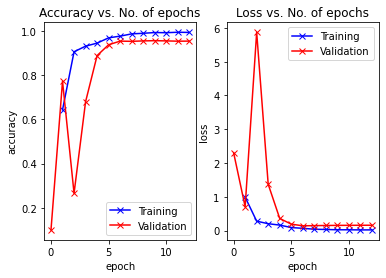

Round [4], train_loss: 0.0235, train_acc: 0.9935, val_loss: 0.1533, val_acc: 0.9567, lr: 0.002700
Train Accuracy: 0.9924±0.00238
[0.99241084, 0.9953785, 0.9924842, 0.9881162, 0.99347126]
Test Accuracy: 0.9583±0.00290
[0.9553097, 0.9637158, 0.95730436, 0.95863414, 0.956687]


In [7]:
train_acc = []
val_acc = []
ALL_ROUND = 5
for round in trange(ALL_ROUND, desc="ROUND"):
    doRound(round)
print("Train Accuracy: %.4f±%.5f" % (numpy.average(train_acc), numpy.std(train_acc)))
print(train_acc)
print("Test Accuracy: %.4f±%.5f" % (numpy.average(val_acc), numpy.std(val_acc)))
print(val_acc)

In [8]:
# 研究网络各层DropConnect权值偏好
for layer in model:
    if isinstance(layer, DropConnect):
        print(layer.w.data.item())

0.013621785677969456
0.18096959590911865
0.2242499738931656
0.1762995719909668
0.25204363465309143
-1.0449254512786865
1.6817878484725952
1.7060426473617554
1.769601821899414
